<a href="https://colab.research.google.com/github/nicoeiris11/fashion-mnist-deep-learning/blob/master/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

cuda:0


Extracting ruta_donde_guardar_datos/FashionMNIST/raw/train-images-idx3-ubyte.gz to ruta_donde_guardar_datos/FashionMNIST/raw


Extracting ruta_donde_guardar_datos/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ruta_donde_guardar_datos/FashionMNIST/raw



Extracting ruta_donde_guardar_datos/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ruta_donde_guardar_datos/FashionMNIST/raw


Extracting ruta_donde_guardar_datos/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ruta_donde_guardar_datos/FashionMNIST/raw
Processing...
Done!
Tamaño del dataset 60000 imagenes.
Clases posibles: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Objeto imagen: <PIL.Image.Image image mode=L size=28x28 at 0x7F34A4FE0F98> - Clase 9
Detalles de la imagen (28, 28) pixeles



/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


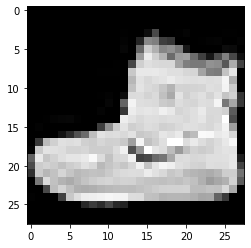

In [ ]:
import matplotlib.pyplot as plt
import torchvision.datasets as dsets

mnist_dataset = dsets.FashionMNIST("ruta_donde_guardar_datos", download=True)

print(f"Tamaño del dataset {len(mnist_dataset)} imagenes.")
print(f"Clases posibles: {mnist_dataset.classes}")

data_idx = 0  # Indice (0-59999) de la imagen a ver
image, label = mnist_dataset[0] 

print(f"Objeto imagen: {image} - Clase {label}")
print(f"Detalles de la imagen {image.size} pixeles")

plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
# Esto permite cambiarle la forma a un tensor aplicandole una transformacion. 

class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return torch.reshape(img, self.new_size)

In [ ]:
import torchvision.transforms as transforms

img_transforms = transforms.Compose([transforms.ToTensor(), ReshapeTransform((-1,))])

# Descargo los datasets
mnist_train_dataset = dsets.FashionMNIST("ruta_donde_guardar_datos", download=True, train=True, transform=img_transforms)

# Separo el train set en train y validation
train_set, val_set = torch.utils.data.random_split(mnist_train_dataset, [int(0.8 * len(mnist_train_dataset)), int(0.2 * len(mnist_train_dataset))])

mnist_test_dataset = dsets.FashionMNIST("ruta_donde_guardar_datos", download=True, train=False, transform=img_transforms)

# Creo objetos DataLoader (https://pytorch.org/docs/stable/data.html) que va a permitir crear batches de data automaticamente.

# Cuantas imagenes obtener en cada iteracion!
BATCH_SIZE = 64

# Creo los loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
# Definicion del modelo que voy a usar.
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardModel(nn.Module):

    def __init__(self, number_classes=10):
        super(FeedForwardModel, self).__init__()
        self.linear1 = nn.Linear(in_features=784, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.output = nn.Linear(in_features=64, out_features=number_classes)
  
    def forward(self, new_input):
        result = F.relu(self.linear1(new_input))
        result = F.relu(self.linear2(result))
        logits = self.output(result)

        return logits


model = FeedForwardModel(number_classes=10)
model

FeedForwardModel(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

LEARNING_RATE = 0.003

ff_model = FeedForwardModel(number_classes=10).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
ff_optimizer = optim.SGD(ff_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [ ]:
def train_model(model, train_loader, val_loader, loss_func, optimizer, epochs):
    for epoch in range(epochs):  # Itero sobre el dataset entero muchas veces

        running_loss = 0.0  

        for i, data in enumerate(train_loader):
            # Los datos son imagenes y la clase de cada una.
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Reseteo los gradientes de los pesos del modelo.
            optimizer.zero_grad()   

            # Obtengo las predicciones para las nuevas imagenes llamando a nuestro modelo.
            predictions = model(images)    

            # Calculo el costo de nuestras predicciones respecto a la verdad
            loss = loss_func(predictions, labels)

            # Computo los gradientes con backward y actualizamos los pesos con un optimizer.step()
            loss.backward()
            optimizer.step()

            # Estadísiticas
            running_loss += loss.item()
            if i % 500 == 499:    # Imprimo luego de 1000 batches de datos
                print(f"Epoch: {epoch + 1}, Batch: {i + 1} - Loss: {running_loss / 500:.5f}")
                running_loss = 0.0


        # Luego de cada epoch de entrenamiento veo la performance (accuracy) en el set de validacion
        with torch.no_grad():
            correct_predictions = 0.0

            for i, data in enumerate(val_loader):
                images, labels = data
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                predictions = model(images)
                predictions = torch.argmax(predictions, dim=1)

                correct_predictions += (predictions == labels).detach().cpu().float().sum().item()

        print(f"Validation accuracy {(100 * correct_predictions / len(val_loader.dataset)):.2f} %")

    return model

In [ ]:
def test_model(model, test_loader):
    # Finalmente reporto la performance en el test set:
    with torch.no_grad():
        correct_predictions = 0.0

        for i, data in enumerate(test_loader):
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            predictions = model(images)
            predictions = torch.argmax(predictions, dim=1)

            correct_predictions += (predictions == labels).detach().cpu().float().sum().item()

    print(f"Test set accuracy {(100 * correct_predictions / len(test_loader.dataset)):.2f} %")

In [ ]:
# Usando las funciones definidas arriba entrenar un modelo es trivial
ff_model = FeedForwardModel(number_classes=10).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
ff_optimizer = optim.SGD(ff_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
ff_model = train_model(ff_model, train_loader, val_loader, loss_func=criterion, optimizer=ff_optimizer, epochs=15)
test_model(ff_model, test_loader)


Epoch: 1, Batch: 500 - Loss: 1.32325
Validation accuracy 77.38 %
Epoch: 2, Batch: 500 - Loss: 0.57732
Validation accuracy 82.87 %
Epoch: 3, Batch: 500 - Loss: 0.49557
Validation accuracy 83.22 %
Epoch: 4, Batch: 500 - Loss: 0.46103
Validation accuracy 84.35 %
Epoch: 5, Batch: 500 - Loss: 0.43820
Validation accuracy 83.93 %
Epoch: 6, Batch: 500 - Loss: 0.41808
Validation accuracy 85.47 %
Epoch: 7, Batch: 500 - Loss: 0.40147
Validation accuracy 85.60 %
Epoch: 8, Batch: 500 - Loss: 0.38654
Validation accuracy 86.06 %
Epoch: 9, Batch: 500 - Loss: 0.37084
Validation accuracy 85.19 %
Epoch: 10, Batch: 500 - Loss: 0.35928
Validation accuracy 86.33 %
Epoch: 11, Batch: 500 - Loss: 0.35046
Validation accuracy 86.61 %
Epoch: 12, Batch: 500 - Loss: 0.34453
Validation accuracy 86.06 %
Epoch: 13, Batch: 500 - Loss: 0.33242
Validation accuracy 86.81 %
Epoch: 14, Batch: 500 - Loss: 0.33020
Validation accuracy 87.26 %
Epoch: 15, Batch: 500 - Loss: 0.32181
Validation accuracy 87.39 %
Test set accuracy 8

## Mejora del modelo anterior

In [ ]:
class FeedForwardModel2HiddenLayers(nn.Module):

    def __init__(self, number_classes=10):
        super(FeedForwardModel2HiddenLayers, self).__init__()
        self.linear1 = nn.Linear(in_features=784, out_features=550)
        self.linear2 = nn.Linear(in_features=550, out_features=120)
        self.output = nn.Linear(in_features=120, out_features=number_classes)

    def forward(self, new_input):
        result = F.relu(self.linear1(new_input))
        result = F.relu(self.linear2(result))
        logits = self.output(result)

        return logits


model = FeedForwardModel2HiddenLayers(number_classes=10)
model

FeedForwardModel2HiddenLayers(
  (linear1): Linear(in_features=784, out_features=550, bias=True)
  (linear2): Linear(in_features=550, out_features=120, bias=True)
  (output): Linear(in_features=120, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim
LEARNING_RATE = 0.0006

ff_model_4 = FeedForwardModel2HiddenLayers(number_classes=10).to(DEVICE)
criterion_4 = nn.CrossEntropyLoss().to(DEVICE)
ff_optimizer_4 = optim.Adam(ff_model_4.parameters(), lr=LEARNING_RATE)

In [ ]:
ff_model_4 = train_model(ff_model_4, train_loader, val_loader, loss_func=criterion_4, optimizer=ff_optimizer_4, epochs=15)
test_model(ff_model_4, test_loader)

Epoch: 1, Batch: 500 - Loss: 0.61727
Validation accuracy 85.58 %
Epoch: 2, Batch: 500 - Loss: 0.38873
Validation accuracy 86.72 %
Epoch: 3, Batch: 500 - Loss: 0.34641
Validation accuracy 87.87 %
Epoch: 4, Batch: 500 - Loss: 0.31519
Validation accuracy 85.72 %
Epoch: 5, Batch: 500 - Loss: 0.29246
Validation accuracy 87.85 %
Epoch: 6, Batch: 500 - Loss: 0.28187
Validation accuracy 88.22 %
Epoch: 7, Batch: 500 - Loss: 0.26092
Validation accuracy 88.75 %
Epoch: 8, Batch: 500 - Loss: 0.25194
Validation accuracy 88.69 %
Epoch: 9, Batch: 500 - Loss: 0.23826
Validation accuracy 88.42 %
Epoch: 10, Batch: 500 - Loss: 0.22887
Validation accuracy 88.73 %
Epoch: 11, Batch: 500 - Loss: 0.21863
Validation accuracy 88.46 %
Epoch: 12, Batch: 500 - Loss: 0.21152
Validation accuracy 89.02 %
Epoch: 13, Batch: 500 - Loss: 0.19748
Validation accuracy 88.74 %
Epoch: 14, Batch: 500 - Loss: 0.19278
Validation accuracy 89.45 %
Epoch: 15, Batch: 500 - Loss: 0.17830
Validation accuracy 88.72 %
Test set accuracy 8

# Solucion con redes convolucionales


In [ ]:
import torchvision.transforms as transforms

# Descargamos los datasets
mnist_train_dataset = dsets.FashionMNIST("ruta_donde_guardar_datos", download=True, train=True, transform=transforms.ToTensor())

# Separamos el train set en train y validation
train_set, val_set = torch.utils.data.random_split(mnist_train_dataset, [int(0.8 * len(mnist_train_dataset)), int(0.2 * len(mnist_train_dataset))])

mnist_test_dataset = dsets.FashionMNIST("ruta_donde_guardar_datos", download=True, train=False, transform=transforms.ToTensor())

# Creamos objetos DataLoader (https://pytorch.org/docs/stable/data.html) que nos va a permitir crear batches de data automaticamente.

# Cuantas imagenes obtener en cada iteracion!
BATCH_SIZE = 64

# Creamos los loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
class ConvolutionalModel(nn.Module):
    def __init__(self, number_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
        
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)   # Regiones de 2x2 con paso 2.
        
        # Estas imagenes son de 28x28 y vamos a aplicar 2 veces la capa de pooling
        # por lo que el resultado es de tamaño 7x7 (28 / 2 / 2).
        # El 16 es porque terminamos con 16 feature maps de 7x7
        
        self.fc1 = nn.Linear(in_features=7*7*8, out_features=128) 
        
        self.output = nn.Linear(in_features=128, out_features=number_classes)
        

    def forward(self, new_input):
        result = self.conv1(new_input)
        result = F.relu(self.pooling_layer(result))
        
        result = self.conv2(result)
        result = F.relu(self.pooling_layer(result))     
        
        # "Achatamos" los feature maps
        result = result.reshape((-1, self.fc1.in_features))
        result = F.relu(self.fc1(result))
        
        return self.output(result)

In [ ]:
conv_model = ConvolutionalModel(number_classes=10).to(DEVICE)

LEARNING_RATE = 0.03

criterion = nn.CrossEntropyLoss().to(DEVICE)
conv_optimizer = optim.SGD(conv_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

conv_model = train_model(conv_model, train_loader, val_loader, loss_func=criterion, optimizer=conv_optimizer, epochs=10)
test_model(conv_model, test_loader)

Epoch: 1, Batch: 500 - Loss: 0.73411
Validation accuracy 86.03 %
Epoch: 2, Batch: 500 - Loss: 0.36803
Validation accuracy 87.95 %
Epoch: 3, Batch: 500 - Loss: 0.31337
Validation accuracy 88.17 %
Epoch: 4, Batch: 500 - Loss: 0.28544
Validation accuracy 88.40 %
Epoch: 5, Batch: 500 - Loss: 0.26898
Validation accuracy 88.72 %
Epoch: 6, Batch: 500 - Loss: 0.26080
Validation accuracy 90.58 %
Epoch: 7, Batch: 500 - Loss: 0.24142
Validation accuracy 90.15 %
Epoch: 8, Batch: 500 - Loss: 0.22999
Validation accuracy 89.73 %
Epoch: 9, Batch: 500 - Loss: 0.22316
Validation accuracy 90.50 %
Epoch: 10, Batch: 500 - Loss: 0.21157
Validation accuracy 90.39 %
Test set accuracy 89.65 %


## Mejora del modelo anterior


In [ ]:
class ConvolutionalModelCustom(nn.Module):
    def __init__(self, number_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)   # Regiones de 2x2 con paso 2.
        
        # Nuestras imagenes son de 28x28 y vamos a aplicar 2 veces la capa de pooling
        # por lo que el resultado es de tamaño 7x7 (28 / 2 / 2).
        # El 16 es porque terminamos con 16 feature maps de 7x7
        
        self.fc1 = nn.Linear(in_features=7*7*32, out_features=620) 
        
        self.output = nn.Linear(in_features=620, out_features=number_classes)
        

    def forward(self, new_input):
        result = self.conv1(new_input)
        result = F.relu(result)
        
        result = self.conv2(result)
        result = F.relu(self.pooling_layer(result))     

        result = self.conv3(result)
        result = F.relu(self.pooling_layer(result))     
        
        # "Achatamos" los feature maps
        result = result.reshape((-1, self.fc1.in_features))
        result = F.relu(self.fc1(result))
        
        return self.output(result)

In [ ]:
conv_model = ConvolutionalModelCustom(number_classes=10).to(DEVICE)

LEARNING_RATE = 0.003

criterion = nn.CrossEntropyLoss().to(DEVICE)
conv_optimizer = optim.Adam(conv_model.parameters(), lr=LEARNING_RATE)

conv_model = train_model(conv_model, train_loader, val_loader, loss_func=criterion, optimizer=conv_optimizer, epochs=10)
test_model(conv_model, test_loader)

Epoch: 1, Batch: 500 - Loss: 0.50492
Validation accuracy 88.04 %
Epoch: 2, Batch: 500 - Loss: 0.28956
Validation accuracy 90.32 %
Epoch: 3, Batch: 500 - Loss: 0.24283
Validation accuracy 91.38 %
Epoch: 4, Batch: 500 - Loss: 0.20293
Validation accuracy 91.18 %
Epoch: 5, Batch: 500 - Loss: 0.17939
Validation accuracy 91.33 %
Epoch: 6, Batch: 500 - Loss: 0.14894
Validation accuracy 91.13 %
Epoch: 7, Batch: 500 - Loss: 0.12787
Validation accuracy 90.35 %
Epoch: 8, Batch: 500 - Loss: 0.10903
Validation accuracy 91.44 %
Epoch: 9, Batch: 500 - Loss: 0.08799
Validation accuracy 91.53 %
Epoch: 10, Batch: 500 - Loss: 0.07021
Validation accuracy 91.80 %
Test set accuracy 91.21 %
